<a href="https://colab.research.google.com/github/OmarMoghazy/LDA-Eigenfaces/blob/main/Face_Recognition_Faces_vs_Non_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image
from google.colab import drive
drive.mount('/content/gdrive')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Face Recognition

## Reading Data

Dataset: https://www.kaggle.com/kasikrit/att-database-of-faces

In [ ]:
label = []
for i in range(1,41):
    for j in range(1,11):
        img = Image.open("/content/gdrive/My Drive/at&t db of faces/s"+str(i) +"/"+ str(j) + '.pgm')
        numpydata = np.asarray(img).flatten()
        if i == 1 and j == 1:
            data = numpydata
        else:
            data = np.vstack((data, numpydata))
        label = np.hstack((label, i))

## Scaling

In [ ]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

## Splitting Data Into Training Set and Testing Set

In [ ]:
# training, testing, training_labels, testing_labels = train_test_split(
#  data, label, test_size=0.3, random_state=42)

In [ ]:
training = data[1::2]
testing = data[::2]

training_labels = label[1::2]
testing_labels = label[::2]

## PCA

### Eigenpair calculations

In [ ]:
mean = np.mean(data, axis=0)
Z = data - mean
covariance = np.cov(Z.T, bias=True)
eigenvalues, eigenvectors = np.linalg.eigh(covariance)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
total_variance = np.sum(eigenvalues)


### Classification

In [ ]:
def classify(training_scaled, testing_scaled, training_labels, testing_labels, neighbors = 1):
  # scaler = StandardScaler()
  # scaler.fit(projected_training_data)
  # training_scaled = scaler.transform(projected_training_data)
  # testing_scaled = scaler.transform(projected_testing_data)

  classifier = KNeighborsClassifier(n_neighbors= neighbors)
  classifier.fit(training_scaled, training_labels)

  predictions = classifier.predict(testing_scaled)
  # print(predictions)

  # print(confusion_matrix(testing_labels, predictions))
  # print(classification_report(testing_labels, predictions))
  return (np.array(predictions), accuracy_score(testing_labels, predictions))

### Projection Matrix

In [ ]:
def get_projection_matrix(eigenvalues, eigenvectors, alpha):
    fr = 0
    sum = 0
    r = 0
    total_variance = np.sum(eigenvalues)
    while fr < alpha:
        sum += eigenvalues[r]
        fr = sum / total_variance
        r = r+1
    projection_matrix = eigenvectors[:,0:r]
    return projection_matrix

### Classifying and Calculating Accuracy for Different Values of k and Alpha

[0.94  0.935 0.945 0.94  0.86  0.855 0.84  0.845 0.83  0.82  0.83  0.815
 0.775 0.765 0.765 0.745]


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Number of Neighbors')]

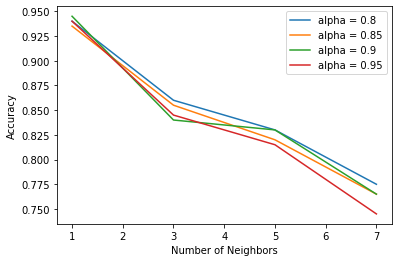

In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]
neighbors = [1,3,5,7]
score_temp = []

for n in neighbors:
  for a in alpha:
    projection_matrix = get_projection_matrix(eigenvalues, eigenvectors, a)
    Z_training = training - mean
    Z_testing = testing - mean
    projected_training_data = Z_training @ projection_matrix
    projected_testing_data = Z_testing @ projection_matrix
    pred, scr = classify(projected_training_data, projected_testing_data, training_labels, testing_labels, n)
    score_temp = np.hstack((score_temp, scr))
print(score_temp)
for i in range(0, 4):
  ax = sns.lineplot(x = neighbors, y = score_temp[i::4], legend='brief')
ax.legend(['alpha = 0.8', 'alpha = 0.85', 'alpha = 0.9', 'alpha = 0.95'])
ax.set(xlabel='Number of Neighbors', ylabel='Accuracy')

## LDA

### Class Means and Sb Matrix

In [ ]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

class_means = np.mean(data[0:10], axis = 0)
for i in range(1,40):
  class_means = np.vstack((class_means, np.mean(data[i*10:i*10+11], axis = 0)))

mean = np.mean(data, axis=0)

sb = 0
nk = 10
for i in range(0,40):
  x = class_means[i] - mean
  sb += 10 * np.outer(x,x.T) 

### S Matrix

In [ ]:
Z = data

for i in range(40):
  for j in range(10):
    Z[j] = Z[j] - class_means[i]

Z_training = Z[1::2]
Z_testing = Z[::2]

training_labels = label[1::2]
testing_labels = label[::2]

# Z_training, Z_testing, training_labels, testing_labels = train_test_split(
#  Z, label, test_size=0.3, random_state=42)

condition = (label == 1)
S = Z[condition].T @ Z[condition]
for i in range(2,41):
  condition = (label == i)
  S += Z[condition].T @ Z[condition]

### Eigenpair Calculations

In [ ]:
S_inv = (np.linalg.inv(S))
S_inv_Sb = S_inv @ sb

eigenvalues_lda, eigenvectors_lda = np.linalg.eigh(S_inv_Sb)

idx_lda = np.argsort(eigenvalues_lda)[::-1]
eigenvalues_lda = eigenvalues_lda[idx_lda]
eigenvectors_lda = eigenvectors_lda[:, idx_lda]

### Projection Matrix

In [ ]:
eigenvectors_lda = eigenvectors_lda[:,0:39]
# print(eigenvectors_lda.shape)

In [ ]:
projected_training_data_lda = Z_training @ eigenvectors_lda
# print(projected_training_data_lda.shape)

In [ ]:
projected_testing_data_lda = Z_testing @ eigenvectors_lda
# print(projected_testing_data_lda.shape)

### Classifying and Calculating Accuracy for Different values of K

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Number of Neighbors')]

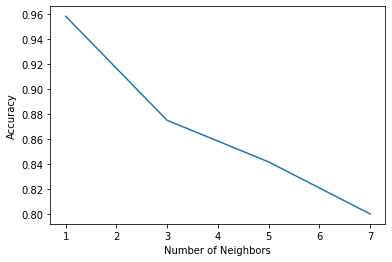

In [ ]:
scores_lda = []
neighbors = [1,3,5,7]
for n in neighbors:
  pred_lda, scr_lda = classify(projected_training_data_lda, projected_testing_data_lda, training_labels, testing_labels, n)
  scores_lda = np.hstack((scores_lda, scr_lda))

ax = sns.lineplot(neighbors, scores_lda)
ax.set(xlabel='Number of Neighbors', ylabel='Accuracy')

# Faces vs Non-Faces

## Converting New Non-Face Images Into the Appropriate Format

Dataset: https://www.kaggle.com/prasunroy/natural-images

In [ ]:
# for i in range(1, 321):
#   img = Image.open("/content/gdrive/My Drive/non faces/nonface (" + str(i) + ").jpg")
#   img = img.convert('L').resize((92,112))
#   img.save('/content/gdrive/My Drive/not face/nonface_' + str(i) + '.pgm')

## Reading Data

In [ ]:
label_7 = np.ones((1,400))

data_7 = data

# change n up to 320
n = 320
for i in range(1, n + 1):
  img = Image.open("/content/gdrive/My Drive/not face/nonface_" + str(i) + ".pgm")
  numpydata = np.asarray(img).flatten()
  data_7 = np.vstack((data_7, numpydata))

label_7 = np.hstack((label_7, np.zeros((1,n))))

Scaling

In [ ]:
scaler = StandardScaler()
scaler.fit(data_7)
data_7 = scaler.transform(data_7)

Splitting into testing set and training set

In [ ]:
training_7 = data_7[1::2]
testing_7 = data_7[::2]

training_labels_7 = label_7[:,1::2]
testing_labels_7 = label_7[:, ::2]

# training_7, testing_7, training_labels_7, testing_labels_7 = train_test_split(
#  data_7, label_7.T, test_size=0.3, random_state=42)

## LDA

### Class Means and B Matrix

In [ ]:
class_means_7 = np.vstack((np.mean(data_7[0:400], axis = 0), np.mean(data_7[400:], axis = 0)))

In [ ]:
x_7 = class_means_7[0] - class_means_7[1]
B_7 = np.outer(x_7, x_7.T)

Z_7 = data_7[0:400] - class_means_7[0]
Z_7 = np.vstack((Z_7, data_7[400:] - class_means_7[1]))

Z_training_7 = Z_7[1::2]
Z_testing_7 = Z_7[::2]

### S Matrix

In [ ]:
S1_7 = Z_7[0:400].T @ Z_7[0:400]
S2_7 = Z_7[400:].T @ Z_7[400:]

S_7 = S1_7 + S2_7

### Eigenpair Calculations

In [ ]:
S_inv_B_7 = np.linalg.inv(S_7) @ B_7

In [ ]:
eigenvalues_7, eigenvectors_7 = np.linalg.eigh(S_inv_B_7)

In [ ]:
# for i in range(eigenvalues_7.size):
  # if eigenvalues_7[i] < 0:
  #   eigenvalues_7[i] = -1 * eigenvalues_7[i]

idx_7 = np.argsort(eigenvalues_7)[::-1]
eigenvalues_7 = eigenvalues_7[idx_7]
eigenvectors_7 = eigenvectors_7[:, idx_7]

### Projection Matrix

In [ ]:
proj_matrix_7 = eigenvectors_7[:,0:39]

In [ ]:
projected_training_data_7 = Z_training_7 @ proj_matrix_7
projected_testing_data_7 = Z_testing_7 @ proj_matrix_7

### Classifying and Calculating Accuracy Scores for different values of K

In [ ]:
scores_7 = []
pred_7, scr_7 = classify(projected_training_data_7, projected_testing_data_7, training_labels_7.T, testing_labels_7.T, 1)
scores_7 = np.hstack((scores_7, scr_7))
success = (pred_7 == testing_labels_7)
df = pd.DataFrame({'Predictions': pred_7, 'Testing Labels': testing_labels_7[0], 'Success': success[0]})
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#  print(df)
df.to_excel('/content/gdrive/My Drive/Success Failure faces vs non faces/Success Rates ' + str(n) + ' non faces.xlsx')
print(scores_7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


[0.92222222]


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Number of non-face images')]

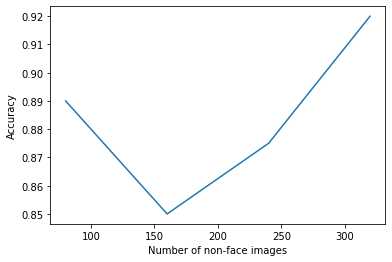

In [ ]:
accuracy = [0.89, 0.85, 0.875, 0.92]
number_of_nonfaces = [80, 160, 240, 320]

ax = sns.lineplot(x=number_of_nonfaces, y=accuracy)
ax.set(xlabel='Number of non-face images', ylabel='Accuracy')